In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import pickle
import matplotlib.pyplot as plt

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
# t1d_mat = file_path + "T1D_final_short.bed"
t1d_mat = file_path + "t1d_final_short_after_loci_filtering.bed"
# t2d_mat = file_path + "T2D_final_short.bed"
t2d_mat = file_path + "t2d_final_short_after_loci_filtering.bed"
topmed_mat = file_path + "topmed_final.bed"
proba_threshold_high = 0.8
proba_threshold_low = 0.000005

# Data Ingestion

In [3]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['VarID', 'Locus', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

proba_threshold_high = 0.01
proba_threshold_low = 0.000006
print("Positive", len(t1d_labels[t1d_labels > proba_threshold_high]), end='; ')
print("Negative", len(t1d_labels[t1d_labels < proba_threshold_low]), end='; ')
print("Unlabelled", len(t1d_labels[(t1d_labels <= proba_threshold_high) & (t1d_labels >= proba_threshold_low)]), end='; ')

Originally 12380 variants. Filtering out 0 variants; left with 12380
Positive 801; Negative 705; Unlabelled 10874; 

In [4]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1

In [5]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

# Logistic Regression

In [16]:
# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Average Accuracy Score"
]
res = pandas.DataFrame(columns=res_columns)

model = LogisticRegression(max_iter=5000)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        known_data_bool = t1d_labels_thresh != -1
        known_data = t1d_data.copy(deep=True)
        known_data.insert(len(known_data.columns), 'label', t1d_labels_thresh)
        known_data.insert(len(known_data.columns), 'known', known_data_bool)
        known_data = known_data[known_data.known == True]
        known_labels = known_data['label']
        known_data = known_data.drop(['label', 'known'], axis=1)
        
        score = np.mean(cross_val_score(model, known_data, y=known_labels, verbose=1, n_jobs=1))
        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, score]

res.to_csv("./logistic_reg_res.csv")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

### Data Normalizing

In [ ]:
# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Average Accuracy Score",
    "Num Positive Variants",
    "Num Negative Variants",
    "Pos/Total ratio",
    "Neg/Total ratio",
    "Pos/Neg ratio"
]
res = pandas.DataFrame(columns=res_columns)

model = LogisticRegression(max_iter=5000)
clf = make_pipeline(Normalizer(), model)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        known_data_bool = t1d_labels_thresh != -1
        known_data = t1d_data.copy(deep=True)
        known_data.insert(len(known_data.columns), 'label', t1d_labels_thresh)
        known_data.insert(len(known_data.columns), 'known', known_data_bool)
        known_data = known_data[known_data.known == True]
        known_labels = known_data['label']
        known_data = known_data.drop(['label', 'known'], axis=1)
        
        # Data stats
        num_pos = len(known_labels[known_labels == 1])
        num_neg = len(known_labels[known_labels == 0])
        pos_tot_ratio = num_pos / len(known_labels)
        neg_tot_ratio = num_neg / len(known_labels)
        pos_neg_ratio = num_pos / num_neg
        
        score = np.mean(cross_val_score(clf, known_data, y=known_labels, verbose=1, n_jobs=1))
        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, score, num_pos, num_neg, pos_tot_ratio, neg_tot_ratio, pos_neg_ratio]

res.to_csv("./logistic_reg_res_normalizer.csv")

# Logit Transform with Linear Regression

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression


class LogitRegression(LinearRegression):
    
    def __init__(self, n_jobs=1):
        super().__init__(n_jobs=n_jobs)

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

model = LogitRegression()
clf = make_pipeline(MinMaxScaler(), model)

score = cross_val_score(clf, t1d_data, y=t1d_labels, verbose=1)
print("Score:", score)

score = cross_val_score(model, t1d_data, y=t1d_labels, verbose=1)
print("Score", score)

score = cross_val_score(LinearRegression(), t1d_data, y=t1d_labels, verbose=1)
print("Score:", score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/sshaul/mykernel/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-6-ce2126a1117d>", line 13, in fit
    return super().fit(x, y)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/linear_model/_b

Score: [        nan         nan         nan         nan -0.07712828]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Score [        nan         nan         nan         nan -0.07712828]
Score: [ -9.40051803 -10.40096784 -13.31879345  -0.39043233  -0.07274569]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished


# Random Forest Regression

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
clf = make_pipeline(Normalizer(), model)

score = cross_val_score(clf, t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

score = cross_val_score(make_pipeline(MinMaxScaler(), model), t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

score = cross_val_score(model, t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Score: [-27.86506345 -35.73057241 -64.44415768  -0.67727799  -0.074933  ]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Score: [-25.94300257 -39.49037374 -55.42690296  -1.10588994  -0.0728041 ]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min


Score: [-22.98273269 -33.48053248 -57.13211678  -1.05701219  -0.07299937]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min finished


# All Regression Models Comparison

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

class LogitRegression(LinearRegression):
    
    def __init__(self, n_jobs=1):
        super().__init__(n_jobs=n_jobs)

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

model = LogitRegression()
clf = make_pipeline(MinMaxScaler(), model)
clf2 = make_pipeline(Normalizer(), model)
clf3 = make_pipeline(StandardScaler(), model)

print("All features logit regression scores")

score = cross_val_score(clf, t1d_data, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

print("Feature selection logit regression scores")

score = cross_val_score(clf, t1d_data_selected, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data_selected, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data_selected, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data_selected, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data_selected, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

print("PCA logit regression scores")

score = cross_val_score(clf, t1d_data_pca, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data_pca, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data_pca, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data_pca, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data_pca, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

# SVC 

In [7]:
from sklearn.svm import SVC, SVR
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler 

# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data, known_labels)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]
        print('train num pos', len(train_labels[train_labels == 1]), 'num neg', len(train_labels[train_labels == 0]))
        
        rus = RandomUnderSampler(random_state=42)
        test_data, test_labels = rus.fit_resample(test_data, test_labels)
        print('num pos', len(test_labels[test_labels == 1]), 'num neg', len(test_labels[test_labels == 0]))

        model.fit(train_data, train_labels)

        # Predict on test
        pred_labels = model.predict(test_data)
        print('pred num pos', len(pred_labels[pred_labels == 1]), 'num neg', len(pred_labels[pred_labels == 0]))

        # Measure accuracy
        acc = accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels)
        rec = recall_score(test_labels, pred_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
        total_fp_score += (fp / (fp + tp))
        total_tp_score += (tp / (fp + tp))
        total_fn_score += (fn / (fn + tn))
        total_tn_score += (tn / (fn + tn))
        num += 1

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", total_fp_score / num, total_tp_score / num, total_tn_score / num, total_fn_score / num)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, total_fp_score / num, total_tp_score / num, total_fn_score / num, total_tn_score / num

In [8]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    


Originally 12380 variants. Filtering out 0 variants; left with 12380


In [ ]:
# high_prob_thresh = 0.01
# low_prob_thresh = 5e-6
high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for high_prob_thresh in high_prob_thresholds:
    for low_prob_thresh in low_prob_thresholds:
        print("High prob:", high_prob_thresh, "Low prob:", low_prob_thresh)
#         model = SelfTrainingClassifier(SVC(C = high_prob_thresh, probability=True))
        model = SelfTrainingClassifier(SVC(probability=True))
#         model = SVR()
        clf = make_pipeline(MinMaxScaler(), model)

        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, high_prob_thresh, low_prob_thresh))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        acc, prec, rec, fp, tp, fn, tn = cv(clf, t1d_data, t1d_labels_thresh)
        res.loc[res.shape[0]] = [high_prob_thresh, low_prob_thresh, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, acc, prec, rec, fp, tp, fn, tn]
        
res.to_csv("./Results/fixed_balanced_testing_SVC.csv")

High prob: 0.01 Low prob: 5e-06
train num pos 601 num neg 184
num pos 62 num neg 62
pred num pos 103 num neg 21
train num pos 601 num neg 184
num pos 62 num neg 62
pred num pos 105 num neg 19
train num pos 601 num neg 184
num pos 62 num neg 62
pred num pos 107 num neg 17
train num pos 601 num neg 184
num pos 62 num neg 62
pred num pos 113 num neg 11
train num pos 601 num neg 184
num pos 62 num neg 62
pred num pos 105 num neg 19
Avg accuracy, precision, recall: 0.5725806451612903 0.542392770985843 0.932258064516129
fp, tp, tn, fn: 0.45760722901415696 0.542392770985843 0.7649337246860467 0.23506627531395333
High prob: 0.01 Low prob: 6e-06
train num pos 600 num neg 529
num pos 176 num neg 176
pred num pos 185 num neg 167
train num pos 600 num neg 529
num pos 176 num neg 176
pred num pos 208 num neg 144
train num pos 600 num neg 529
num pos 176 num neg 176
pred num pos 181 num neg 171
train num pos 600 num neg 529
num pos 176 num neg 176
pred num pos 205 num neg 147
train num pos 600 num n

pred num pos 859 num neg 173
train num pos 2656 num neg 1549
num pos 516 num neg 516
pred num pos 842 num neg 190
train num pos 2656 num neg 1549
num pos 516 num neg 516
pred num pos 888 num neg 144
train num pos 2656 num neg 1549
num pos 516 num neg 516


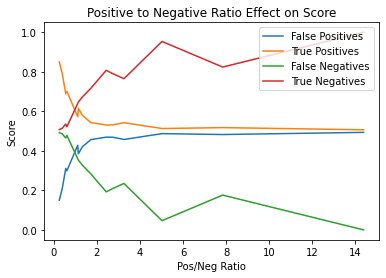

In [9]:
t1d_res = pandas.read_csv("./Results/fixed_balanced_testing_SVC.csv")
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

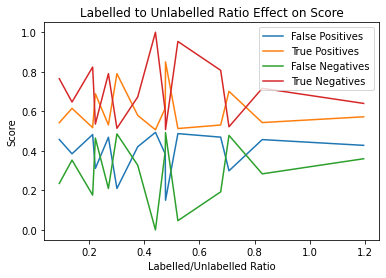

In [10]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

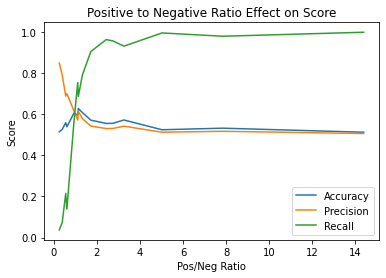

In [11]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

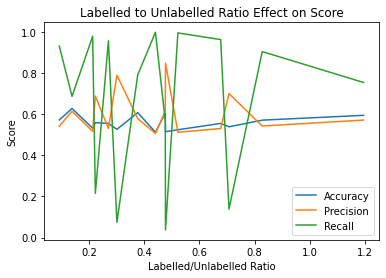

In [12]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

# SVR

In [4]:
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score

# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

Originally 12380 variants. Filtering out 0 variants; left with 12380


In [20]:
model = SVR()
clf = make_pipeline(MinMaxScaler(), model)
clf2 = make_pipeline(Normalizer(), model)
clf3 = make_pipeline(StandardScaler(), model)

print("SVR scores")

score = cross_val_score(model, t1d_data, y=t1d_labels)
print("SVR Score, no normalizing", np.mean(score))

score = cross_val_score(clf, t1d_data, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))



SVR scores


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/svm/_base.py", line 171, in fit
    accept_large_sparse=False)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/utils/validation.py", line 821, in check_X_y
    estimator=estimator)
  File "/home/

SVR Score, no normalizing nan


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

MinMaxScaler normalized Score: nan


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

Normalizer Score: nan
Standard Scaler Score: nan


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

model = SVR()
clf = make_pipeline(MinMaxScaler(), model)

pipeline = Pipeline([
    ('mms', MinMaxScaler()),
    ('svr', SVR()),
])

params = {
    'svr__epsilon': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]
}

grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
t0 = time()
grid_search.fit(t1d_data, t1d_labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['mms', 'svr']
parameters:
{'svr__epsilon': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001], 'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]}
Fitting 5 folds for each of 140 candidates, totalling 700 fits
done in 4624.729s

Best score: -17.438
Best parameters set:
	svr__C: 9.1
	svr__epsilon: 0.0001


In [5]:
# only bin data

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'bin' not in col])

model = SVR()
clf = make_pipeline(MinMaxScaler(), model)

pipeline = Pipeline([
    ('mms', MinMaxScaler()),
    ('svr', SVR()),
])

params = {
    'svr__epsilon': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]
}

grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
t0 = time()
grid_search.fit(t1d_data, t1d_labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['mms', 'svr']
parameters:
{'svr__epsilon': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001], 'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]}
Fitting 5 folds for each of 140 candidates, totalling 700 fits
done in 1330.931s

Best score: -17.663
Best parameters set:
	svr__C: 9.1
	svr__epsilon: 0.0001


In [26]:
# removing duplicates
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

t1d_labels = t1d_labels[~t1d_data.duplicated()]
t1d_data = t1d_data.drop_duplicates()

model = SVR()
clf = make_pipeline(MinMaxScaler(), model)

pipeline = Pipeline([
    ('mms', MinMaxScaler()),
    ('svr', SVR()),
])

params = {
    'svr__epsilon': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]
}

grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
t0 = time()
grid_search.fit(t1d_data, t1d_labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['mms', 'svr']
parameters:
{'svr__epsilon': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001], 'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]}
Fitting 5 folds for each of 140 candidates, totalling 700 fits
done in 3028.170s

Best score: -22.507
Best parameters set:
	svr__C: 9.1
	svr__epsilon: 1e-09


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

model = SVR()
clf = make_pipeline(MinMaxScaler(), model)

pipeline = Pipeline([
    ('mms', MinMaxScaler()),
    ('svr', SVR()),
])

params = {
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'svr__epsilon': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]
}

grid_search = GridSearchCV(clf, params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
t0 = time()
grid_search.fit(t1d_data, t1d_labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['mms', 'svr']
parameters:
{'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 'svr__epsilon': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001], 'svr__C': [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11]}
Fitting 5 folds for each of 700 candidates, totalling 3500 fits


KeyboardInterrupt: 